<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></li></ul></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import os
import numpy as np
import re
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [3]:
import nltk
nltk.download("wordnet")
nltk.download("punkt")


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download("omw-1.4")
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk import word_tokenize, sent_tokenize, FreqDist
from collections import defaultdict, Counter
import string
import requests
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
data=pd.read_csv("/datasets/toxic_comments.csv",index_col=0)

In [7]:
data.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
# найдем уникальные значения для столбца "toxic", который будет у нас целевым признаком
data.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

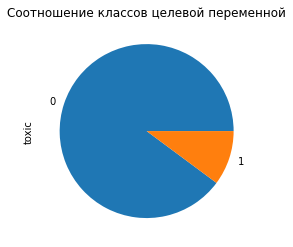

In [10]:
data['toxic'].value_counts().plot(kind='pie',title='Соотношение классов целевой переменной');

In [11]:
df = pd.DataFrame(data)

In [12]:
# переведем текст в нижний регистр
df['text'] = df['text'].str.lower()

In [13]:
df['length'] = df['text'].apply(len)

In [14]:
df.head()


,text,toxic,length
0,explanation\nwhy the edits made under my usern...,0,264
1,d'aww! he matches this background colour i'm s...,0,112
2,"hey man, i'm really not trying to edit war. it...",0,233
3,"""\nmore\ni can't make any real suggestions on ...",0,622
4,"you, sir, are my hero. any chance you remember...",0,67


In [15]:
data.sample()

,text,toxic,length
25139,there's a logic problem here guys. if nobody s...,0,304


In [16]:
# сделаем срезы по токсичным и нетоксичным комментариям
toxic = df[df['toxic'] == 1]
nontoxic = df[df['toxic'] != 1]

In [17]:
# инициализируем Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [18]:
# напишем функцию для pos-тегов - маркировки частей речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
# Lemmatize corpus with the appropriate POS tag
# print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(lem(clear_text(corpus[0])))])

In [19]:
# напишем функцию для очистки и лемматизации текста с маркированными частями речи
def clear_text(text):
    reg = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = reg.split()
    lemm = []
    # в цикле лемматизируем очищенный текст
    for i in range(len(clear)):
      lemm.append(lemmatizer.lemmatize(clear[i], get_wordnet_pos(clear[i])))
    return " ".join(lemm)

In [20]:
# применим функцию к столбцу "текст" и создадим столбец с лемматризированным текстом
# %%time
df['lemmatized_text'] = df['text'].apply(clear_text)

In [21]:
df.head()

,text,toxic,length,lemmatized_text
0,explanation\nwhy the edits made under my usern...,0,264,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,112,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,233,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,622,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,67,you sir be my hero any chance you remember wha...


In [22]:
# сделаем срез по токсичным комментариям
toxic_lem = df[df['toxic'] ==1]

In [23]:
corpus = list(toxic_lem['lemmatized_text'])



In [24]:
# чтобы почистить мешок слов, найдём стоп-слова, то есть слова без смысловой нагрузки.
stop_words = list(nltk_stopwords.words('english'))

# чтобы преобразовать корпус текстов в мешок слов, обратимся к классу CountVectorizer()
# создадим счетчик: зададим максимальное значение признаков 20 наиболее часто встречающихся слов
# и передадим стоп-слова в счетчик векторов
count_vect = CountVectorizer(max_features=20, stop_words=stop_words)#

# создадим мешок слов bow, от англ. bag of words.
# передадим счётчику корпус текстов, вызвав функцию fit_transform().
# счётчик выделит из корпуса уникальные слова и посчитает количество их вхождений в каждом тексте корпуса.
bow = count_vect.fit_transform(corpus)


In [25]:
# разделим выборки на обучающую, валидационную и тестовую в пропорции 60%-20%-20%
target = df['toxic']
features = df['lemmatized_text']

In [26]:
#указываем stratify=target, чтобы сохранить соотношение классов при разделении
#сначала разделим на обучающую и тестовую в соотношении 60%-40%
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)


In [27]:
#разделим тестовую выборку пополам на тестовую и валидационную
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.50, random_state=12345, stratify=target_test)

In [28]:
# проверим выборки на дисбаланс классов
print(target_train.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')
print(target_valid.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')
print(target_test.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')

0    89.8%
1    10.2%
Name: toxic, dtype: object
0    89.8%
1    10.2%
Name: toxic, dtype: object
0    89.8%
1    10.2%
Name: toxic, dtype: object


In [29]:
# найдём стоп-слова, то есть слова без смысловой нагрузки
# для этого вызовем функцию stopwords.words(), передадим ей аргумент
# 'english' для английского языка
stopwords = list(nltk_stopwords.words('english'))

# при создании счётчика передадим список стоп-слов в счётчик tfidf():
count_tf_idf = TfidfVectorizer(stop_words=stopwords)


думаю хотя причины удаления стоп-слов могут быть разными для CountVectorizer и TF-IDF, в обоих случаях удаление стоп-слов может быть полезным для повышения качества модели и снижения размерности данных. к примеру удаление стоп-слов помогает снизить размерность и повысить производительность модели при использовании TF-IDF. а CountVectorizer преобразует текстовые данные в матрицу,поэтому удаление стоп-слов в CountVectorizer как я понимаю  снижает размерность матрицы и тем самым улучшает производительность модели.

In [30]:
train_tf_idf = count_tf_idf.fit_transform(features_train)
#valid_tf_idf = count_tf_idf.transform(features_valid)
test_tf_idf = count_tf_idf.transform(features_test)

In [31]:
print("Размер матрицы:", train_tf_idf.shape)
#print("Размер матрицы:", valid_tf_idf.shape)
print("Размер матрицы:", test_tf_idf.shape)

Размер матрицы: (127433, 132712)
Размер матрицы: (15930, 132712)


Провёла лемматизацию и очистила текст от лишних символов.
Подготовила выборки.

## Обучение

In [32]:
parameters = {
    'C': [10],  # были варианты: 1, 5, 15
    'penalty': ['l2'],  # был вариант: 'l1'
    'max_iter': [100],  # были варианты: 50, 200, 250
}

In [33]:
# обучим модель логистической регрессии,
# укажем гиперпараметр class_weight='balanced'
# найдем наилучшее значение С

model = LogisticRegression(class_weight='balanced',
                          random_state=12345,
                          max_iter=1000,
                          solver='liblinear')

lin_grid = GridSearchCV(model, parameters, scoring='f1', cv=3)
# обучим модель на тренировочной выборке
lin_grid.fit(train_tf_idf, target_train)
lin_fit_score = lin_grid.best_score_
print(f'Лучший показатель F1: {lin_fit_score:.3f}')

# найдем предсказания на валидационной выборке
#predicted_valid = model.predict(valid_tf_idf)

    # напечатаем значение метрики F1
#print("F1_score:", f1_score(target_valid, predicted_valid))
#print('')
print()

Лучший показатель F1: 0.759



In [34]:
from sklearn.pipeline import Pipeline

RandomForestClassifier

In [35]:
classifier_rf = RandomForestClassifier()

In [36]:
pipe_rf = Pipeline(
    [
        ('tf_idf', TfidfVectorizer(stop_words=stop_words)),
        ('clf', classifier_rf)
    ]
)

params_rf = {
             'clf__random_state': [12345],
             'clf__min_samples_leaf': range(2, 10, 2),
             'clf__class_weight': ['balanced'],
             'clf__n_estimators': range(900, 1000, 100),
             'clf__max_depth': range(20, 30, 10)
             }

In [37]:
import time

In [38]:
%%time
start = time.time()
grid_rf = GridSearchCV(pipe_rf,
                       scoring='f1',
                       cv=5,
                       param_grid=params_rf,
                       n_jobs=-1,
                       verbose=3,
                       refit=True
)
grid_rf.fit(features_train, target_train)
end = time.time()
f_rf=round(end-start,2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=2, clf__n_estimators=900, clf__random_state=12345; total time=  56.4s
[CV 2/5] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=2, clf__n_estimators=900, clf__random_state=12345; total time=  58.0s
[CV 3/5] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=2, clf__n_estimators=900, clf__random_state=12345; total time=  55.6s
[CV 4/5] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=2, clf__n_estimators=900, clf__random_state=12345; total time=  53.5s
[CV 5/5] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=2, clf__n_estimators=900, clf__random_state=12345; total time=  53.2s
[CV 1/5] END clf__class_weight=balanced, clf__max_depth=20, clf__min_samples_leaf=4, clf__n_estimators=900, clf__random_state=12345; total time=  48.4s
[CV 2/5] END clf__class_weig

In [39]:
grid_rf.best_params_

{'clf__class_weight': 'balanced',
 'clf__max_depth': 20,
 'clf__min_samples_leaf': 2,
 'clf__n_estimators': 900,
 'clf__random_state': 12345}

In [40]:
best_f1_rf = grid_rf.best_score_
print(f'Best F1 score: {best_f1_rf:.3f}')

Best F1 score: 0.408


LGBMClassifier

пробую модель LGBMClassifier с учетом информации полученной по ссылкам(очень полезные ссылки), с помощью функции torch.cuda.empty_cache() вызываю после блока кода, в котором интенсивно используется память графического процессора. что очистит кеш графического процессора и освобождает любую незанятую память. 

In [41]:
import torch

# Enable GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

In [42]:
from lightgbm import LGBMClassifier

In [43]:
classifier_lgb = LGBMClassifier()

In [44]:
pipe_lgb = Pipeline(
    [
        ('tf_idf', TfidfVectorizer(stop_words=stop_words)),
        ('clf', classifier_lgb)
    ]
)

params_lgb = {
             'clf__random_state':[12345],
             'clf__boosting_type': ['gbdt'],
             'clf__class_weight': ['balanced'],
             'clf__objective': ['binary'],
             }

In [45]:
%%time
start = time.time()
grid_lgb = GridSearchCV(pipe_lgb,
                       scoring='f1',
                       cv=5,
                       param_grid=params_lgb,
                       n_jobs=-1,
                       verbose=2,
                       refit=True 
)
grid_lgb.fit(features_train, target_train)
end = time.time()
f_lgb=round(end-start,2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END clf__boosting_type=gbdt, clf__class_weight=balanced, clf__objective=binary, clf__random_state=12345; total time= 1.7min
[CV] END clf__boosting_type=gbdt, clf__class_weight=balanced, clf__objective=binary, clf__random_state=12345; total time= 1.8min
[CV] END clf__boosting_type=gbdt, clf__class_weight=balanced, clf__objective=binary, clf__random_state=12345; total time= 2.0min
[CV] END clf__boosting_type=gbdt, clf__class_weight=balanced, clf__objective=binary, clf__random_state=12345; total time= 1.7min
[CV] END clf__boosting_type=gbdt, clf__class_weight=balanced, clf__objective=binary, clf__random_state=12345; total time= 1.6min
CPU times: user 10min 4s, sys: 1.5 s, total: 10min 6s
Wall time: 10min 33s


In [46]:
grid_lgb.best_params_

{'clf__boosting_type': 'gbdt',
 'clf__class_weight': 'balanced',
 'clf__objective': 'binary',
 'clf__random_state': 12345}

In [47]:
best_f1_lgb = grid_lgb.best_score_
print(f'Best F1 score: {best_f1_lgb:.3f}')

Best F1 score: 0.732


DecisionTreeClassifier

In [48]:
model = DecisionTreeClassifier(random_state=12345)
parameter = {
    'max_depth': range(1, 5)}
model_random = GridSearchCV(model, parameter, n_jobs=-1)
model_random.fit(train_tf_idf, target_train)
model_random_fit_score = model_random.best_score_
print(f'Лучший показатель F1: {model_random_fit_score:.3f}')

Лучший показатель F1: 0.931


у модели достаточно высокий показатель который является мерой баланса между точностью и полнотой модели, где 1 соответствует идеальной модели. но не смотря на это модель обучается очень долго даже при глубине 5, по идее глубину надо брать в десятки раз больше. (параметры задавала и другие, но результата не дождалась).

## Выводы

In [53]:
predictions = lin_grid.predict(test_tf_idf)
lin_f1 = f1_score(target_test, predictions)
print(
    f'F1-score: {lin_f1:.3f}\n')

F1-score: 0.761



Удалось достичь нужной выличены f1 меры на тестовой выборке.
Общий вывод
Лучший результат показала модель Логистическя регрессия.
Достигнут целевой порог — F1-score= 0.761 выше 0.75.
Плюс у этой модели лучшай скорость обучения.
Для текущей задачи — отправки токсичных комментариев на модерацию — это наиболее существенный показатель.
Так меньше всего токсичных комментариев по ошибке.

попробывала использовать подход Берт.обработала данные выполнила разбивку на токены и установила ограничение на длину последовательности токенов (для около 400 слов). При произведение вычисления эмбеддингов для модели BERT на фрагменте кода который только инициализирует и перемещает модель BERT на устройство, но не выполняет никаких конкретных операций или задач с использованием модели все работает, далее ядро умирает.   прочитала по представленным ссылкам, что для работы с подобными моделями также нужна хорошая оперативка, у меня комп не очень мощный. дальше не смогла пойти по этому пути. поняла что после вычисления эмбеддингом, выделяю также признаки features_bert = np.concatenate(embeddings)
target_bert = data_for_bert['toxic'][0:len(features_bert)], делю на трейн и тест, и обучаю теже самые модели, скорость обучения по идее станет выше. а вот показатель F1 не поняла, по идее как он должен изменится? 

#### Общий вывод: 
Данные загружены и подготовлены, подготовка данных не заняла много времени.
Обучены разные модели.
Для выполнения проекта применять BERT необязательно, я не применила.Логистическая регрессия в кооперативе с TF-IDF векторизатором показала себя с  наилучшим результатом, поскольку подготовка и кодирование занимает около 25 минут, обучение регрессии (около 4 минут), предсказание - мгновенное. RandomForestClassifier() около 15 минут.
Лемматизация текста занимает около 15 минут. На этот процесс не влияет применение графического процессора.
Процесс векторизации подготовленного текста с помощью TfidfVectorizer - мгновенный. Слова, не имеющие смысловой нагрузки - удалены.
Логистическая регрессия имеет значение целевой метрики F1 = 0.759
  LGBM F1 = 0.732. 

Итоговое значение метрикики F1 достигнуто.
Модель CatBoost может выдать предсказания более высшего качества, но для этого требуется более крапотливая настройка её гиперпараметров и дополнительное время работы. Процесс сильно зависим от технических мощностей компьютера/сервера.